In [2]:
# Some standard definitions and some new:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.time import Time
import pylab
import glob
import time
import scipy.signal
import matplotlib.cm as cm
from astropy.stats import sigma_clip
import scipy.ndimage.interpolation as interp
from scipy.ndimage.interpolation import shift
import astropy
from astropy.stats import LombScargle
from photutils import DAOStarFinder
import os
import pandas as pd
from collections import Counter
from HDI_io import construct_astrometry
import math
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
# photometric utilities
from photutils import DAOStarFinder,aperture_photometry, CircularAperture, CircularAnnulus

%matplotlib inline

In [7]:
image

['/Volumes/ScienceSSD/Data/V410_2019_coord.fits']

In [53]:
direct = os.getcwd()
field = 'V410'
year = '2018'

if field in ('V410', 'HL Tau'):
    fieldname = field
else:
    fieldname = 'Std/HG87'

image = glob.glob(direct+'/Data/'+field+'*'+year+'*coord*.fit*') #image with coordinates

datadir = direct+'/Data/'

hdulist = fits.open(image[0])

hdr_wcs = hdulist[0].header

world = construct_astrometry(hdr_wcs)

## Making Table of Survey Data

In [62]:
im_dat = fits.getdata(image[0]) #reference image
bkg_sigma = 5
nsigma = 10

daofind = DAOStarFinder(fwhm=4., threshold=nsigma*bkg_sigma) #finding stars

sources = daofind(im_dat)
aprad = 8

xpos = np.array(sources['xcentroid'])
ypos = np.array(sources['ycentroid'])
positions = (xpos,ypos) #star positions

taura,taudec = world.all_pix2world(xpos,ypos,0) #
survey_csv = glob.glob(direct+'/Survey*'+field+'*.csv') #finding surveys
master_data = pd.DataFrame({'RAJ2000':taura,'DEJ2000':taudec}) #making master dataframe with RADEC
columnsTitles=["RAJ2000","DEJ2000"]
master_data=master_data.reindex(columns=columnsTitles) #getting the column titles

df = pd.DataFrame({'X_pos':xpos})
master_data = pd.concat([master_data,df],axis = 1) #mash it on the end of the final dataframe

df = pd.DataFrame({'Y_pos':ypos})
master_data = pd.concat([master_data,df],axis = 1) #mash it on the end of the final dataframe

In [63]:
color_list = ['red','blue','pink','orange','white','yellow','purple'] #colors for the DS9 list

for ind in range(0,len(survey_csv)): #for all the surveys
    survey = pd.read_csv(survey_csv[ind]) #read the survey
    null_surv = survey.isnull() 
    new_survey = 0
    cut1 = 'Survey Data - ' #getting the name of the survey from the csv title
    cut2 = '.csv'
    stuff1 = survey_csv[ind].split(cut1)
    stuff2 = stuff1[1].split(cut2)
    mag_cols = [col for col in survey.columns if 'mag' in col] #finding the columns with magnitudes
    data = np.empty((len(taura),len(mag_cols),)) #building empty array to fill with mags
    data[:] = np.nan #making the array full of nans
    file = open(stuff2[0]+'matched_sources.reg','w') #opening a survey specific reg file
    aprad = 8+ind
    
    for star in range(0,len(survey)): #for every star in the survey
        s_ra = survey['RAJ2000'][star] #ra for survey star
        s_de = survey['DEJ2000'][star] #dec for survey star
        try:
            pot_ra = np.where(np.abs(taura-s_ra)<(3e-3))[0] #find where the known stars RA is close to the surveys
            pot_de = np.where(np.abs(taudec-s_de)<(3e-3))[0] #same for DEC
            for jj in range(0,len(pot_ra)): #for every potential match in RA
                for rr in range(0,len(pot_de)): #and in DEC
                    if pot_ra[jj]==pot_de[rr]: #if the index matches for RA and DEC
                        #print(str(pot_ra[jj])+' , '+str(pot_de[rr]))
                        for mag in range(0,len(mag_cols)): #grab the mag for that star
                            data[pot_ra[jj],mag] = survey[mag_cols[mag]][star] #put it in the data array
                        file.write('circle '+str(xpos[pot_ra[jj]])+' '+str(ypos[pot_de[rr]])+' '+str(int(aprad))+' # width='+str(ind+3)+' color='+color_list[ind]+'\n')
        except: # if theres no matches skip
            pass

        
    for mag in range(0,len(mag_cols)): #for all the magnitudes in the survey
        df = pd.DataFrame({stuff2[0]+' '+mag_cols[mag]:data[:,mag]}) #make the array a dataframe
        master_data = pd.concat([master_data,df],axis = 1) #mash it on the end of the final dataframe
    file.close()

# Reference Star Finding

In [64]:
ref_ind = {}
ref_star_coord = pd.read_csv('reference_stars.csv')

aprad=12.  # aperture radius
skybuff=4.  # sky annulus inner radius
skywidth=8.  # sky annulus outer radius
ind = 0
for ii in range(0,len(ref_star_coord)):
    ra = ref_star_coord['RAJ2000'][ii]
    dec = ref_star_coord['DEJ2000'][ii]
    #ref_ind[ind] = (master_data.loc[(master_data['RAJ2000']>=(ref_star_coord['RAJ2000'][ind]-1e-2)) & (master_data['RAJ2000']<=(ref_star_coord['RAJ2000'][ind]+1e-2))].index.astype(int)[0])
    try:
        ra_ind = master_data.loc[(master_data['RAJ2000']>=(ra-0.0001)) & (master_data['RAJ2000']<=(ra+0.0001))].index.astype(int)[0]
        dec_ind = master_data.loc[(master_data['DEJ2000']>=(dec-0.0001)) & (master_data['DEJ2000']<=(dec+0.0001))].index.astype(int)[0]
        #for ii in range(0,len(ra_ind))
        print(ra_ind)
        print(dec_ind)
        print('done')
        ref_ind[ind]=ra_ind
        ind=ind+1
    except:
        pass
#     if ra_ind==dec_ind:
#         ref_ind[ind]=ra_ind
print(ref_ind)
# file = open('ref_stars_check.reg','w')
# for star in range(0,len(ref_ind)):
#     file.write('circle '+str(xpos[ref_ind[star]])+' '+str(ypos[ref_ind[star]])+' '+str(int(aprad))+' # width=2 color='+'red'+'\n')
#     file.write('circle '+str(xpos[ref_ind[star]])+' '+str(ypos[ref_ind[star]])+' '+str(int(aprad+skybuff))+' # width=2 color='+'blue'+'\n')
#     file.write('circle '+str(xpos[ref_ind[star]])+' '+str(ypos[ref_ind[star]])+' '+str(int(aprad+skybuff+skywidth))+' # width=2 color='+'blue'+'\n')
    
# file.close()

6
6
done
38
38
done
79
79
done
145
144
done
164
164
done
169
169
done
188
188
done
195
195
done
337
337
done
{0: 6, 1: 38, 2: 79, 3: 145, 4: 164, 5: 169, 6: 188, 7: 195, 8: 337}


In [65]:
ind = 2
ra = ref_star_coord['RAJ2000'][ind]
dec = ref_star_coord['DEJ2000'][ind]
print(master_data.loc[(master_data['RAJ2000']>=(ra-0.0001)) & (master_data['RAJ2000']<=(ra+0.0001))])
print(master_data.loc[(master_data['DEJ2000']>=(dec-0.0001)) & (master_data['DEJ2000']<=(dec+0.0001))])

      RAJ2000    DEJ2000        X_pos       Y_pos  APASS_V410 Vmag  \
79  64.676633  28.194827  1693.320092  620.208917           13.981   

    APASS_V410 e_Vmag  UCAC4_V410 Vmag  UCAC4_V410 e_Vmag  UCAC4_V410 rmag  \
79              0.091           13.981                9.0           13.329   

    UCAC4_V410 e_rmag  UCAC4_V410 imag  UCAC4_V410 e_imag  USNOB_V410 R1mag  \
79                7.0           12.428                7.0             13.49   

    USNOB_V410 R2mag  USNOB_V410 Imag  REF_APASS_V410 Vmag  \
79             13.03            11.48               13.981   

    REF_APASS_V410 r'mag  REF_APASS_V410 i'mag  
79                13.329                12.428  
      RAJ2000    DEJ2000        X_pos       Y_pos  APASS_V410 Vmag  \
79  64.676633  28.194827  1693.320092  620.208917           13.981   

    APASS_V410 e_Vmag  UCAC4_V410 Vmag  UCAC4_V410 e_Vmag  UCAC4_V410 rmag  \
79              0.091           13.981                9.0           13.329   

    UCAC4_V410 e_rmag 

In [66]:
ref_ind = {}
jj = 0

new_survey = 0
for ind in range(0,len(master_data)): #for every row in master data
    null_surv = master_data.isnull() #generate a master null frame
    if null_surv[ind:ind+1].any(axis='columns')[ind]==False: #if the row has no nulls
        try:
            data = master_data[ind:ind+1] #grabbing the data at the point w/o nulls
            new_survey = new_survey.append(data,ignore_index=True) #attempting to put it into a separate survey
            ref_ind[jj] = ind
            print(ind)
            jj=jj+1
        except AttributeError: 
            new_survey = data
            ref_ind[jj] = ind
            print(ind)
            jj+1
    
header = ["RAJ2000","DEJ2000"]
new_survey.to_csv(field+'all_surv_stars.csv', columns = header)

6
38
79
145
164
169
188
195
337


In [67]:
ref_ind

{0: 38, 1: 79, 2: 145, 3: 164, 4: 169, 5: 188, 6: 195, 7: 337}

# STD STAR COORD and DATA

In [9]:
from astropy.coordinates import SkyCoord
from astropy import units as u

std = 'HG87'
if std=='HG87':
    coord = '04:04:34 +25:08:51'
elif std=='Ross47':
    coord = 'stuff'

std_coord = SkyCoord(coord, unit=(u.hourangle, u.deg)) #from SIMBAD
std_ra = std_coord.ra.degree
std_dec = std_coord.dec.degree

std_ind = {}
num = 0

#locating the indexes where the ra and dec match
ra_indexes = (master_data.loc[(master_data['RAJ2000']>=(std_ra-2e-3)) & (master_data['RAJ2000']<=(std_ra+2e-3))].index.astype(int))
de_indexes = (master_data.loc[(master_data['DEJ2000']>=(std_dec-2e-3)) & (master_data['DEJ2000']<=(std_dec+2e-3))].index.astype(int))

try:
    for ra_ind in range(0,len(ra_indexes)): 
        for de_ind in range(0,len(de_indexes)):
            if ra_indexes[ra_ind] == de_indexes[de_ind]: #if the indexes match
                std_ind[num] = ra_indexes[ra_ind] #add to the std_ind
                num = num+1
except:
    pass

if len(std_ind)>1:
    print('MORE THAN ONE STAR IDENTIFIED AS STD, CHECK PARAMETERS') #uh oh, there's more than one 'std'

std_mag = [master_data['APASS_'+field+' Vmag'][std_ind[0]], master_data['USNOB_'+field+' R2mag'][std_ind[0]], master_data['USNOB_'+field+' Imag'][std_ind[0]]]
print(std_mag)

#for tagging the std in the master data frame
df = pd.DataFrame(index=range(0,len(taura)),columns=['ID'])
df['ID'][std_ind[0]] = 'Std'
master_data = pd.concat([master_data,df],axis = 1) #mash it on the end of the final dataframe


KeyError: 0

In [7]:
ra_indexes

Int64Index([39, 108, 188, 276, 626, 679, 727, 776, 820, 871, 898, 945, 950,
            1136, 1216],
           dtype='int64')

# TARGET STAR IDENTIFICATION

In [68]:
tar_ind = {}
pot_tar_star_data = pd.read_csv('Target Coord.csv')
col = pot_tar_star_data.columns
tar_star_data = pd.DataFrame(columns=col)

aprad=15.  # aperture radius
skybuff=4.  # sky annulus inner radius
skywidth=8.  # sky annulus outer radius

num = 0
numbers = {}

for ind in range(0,len(pot_tar_star_data)):
    ra_indexes = (master_data.loc[(master_data['RAJ2000']>=(pot_tar_star_data['RA'][ind]-1e-3)) & (master_data['RAJ2000']<=(pot_tar_star_data['RA'][ind]+1e-3))].index.astype(int))
    de_indexes = (master_data.loc[(master_data['DEJ2000']>=(pot_tar_star_data['DEC'][ind]-1e-3)) & (master_data['DEJ2000']<=(pot_tar_star_data['DEC'][ind]+1e-3))].index.astype(int))
    try:
        for ra_ind in range(0,len(ra_indexes)):
            for de_ind in range(0,len(de_indexes)):
                if ra_indexes[ra_ind] == de_indexes[de_ind]:
                    tar_ind[num] = ra_indexes[ra_ind]
                    numbers[num] = ind
                    num = num+1
                    
    except:
        pass
    
file = open('tar_coord.reg','w')
for star in range(0,len(tar_ind)):
    file.write('circle '+str(xpos[tar_ind[star]])+' '+str(ypos[tar_ind[star]])+' '+str(int(aprad))+' # width=2 color='+'red'+' text={'+pot_tar_star_data['Name'][numbers[star]]+'}'+'\n')
    file.write('circle '+str(xpos[tar_ind[star]])+' '+str(ypos[tar_ind[star]])+' '+str(int(aprad+skybuff))+' # width=2 color='+'blue'+'\n')
    file.write('circle '+str(xpos[tar_ind[star]])+' '+str(ypos[tar_ind[star]])+' '+str(int(aprad+skybuff+skywidth))+' # width=2 color='+'blue'+'\n')
    
file.close()

In [69]:
tar_name = {}
for star in range(0,len(tar_ind)):
    tar_name[star] = pot_tar_star_data['Name'][numbers[star]]
tar_name

{0: 'KPNO 10',
 1: 'V410 X-ray 1',
 2: 'V410 X-ray 3',
 3: 'DD Tau A+B',
 4: 'CZ Tau A+B',
 5: 'V892 Tau',
 6: 'CoKu Tau 1',
 7: 'V410 X-ray 6',
 8: 'FQ Tau A+B',
 9: 'V819 Tau',
 10: 'FR Tau'}

In [13]:
ind = 18
ra_indexes = (master_data.loc[(master_data['RAJ2000']>=(pot_tar_star_data['RA'][ind]-3e-3)) & (master_data['RAJ2000']<=(pot_tar_star_data['RA'][ind]+3e-3))].index.astype(int))
de_indexes = (master_data.loc[(master_data['DEJ2000']>=(pot_tar_star_data['DEC'][ind]-3e-3)) & (master_data['DEJ2000']<=(pot_tar_star_data['DEC'][ind]+3e-3))].index.astype(int))
print(ra_indexes)
print(de_indexes)

Int64Index([8, 75, 286], dtype='int64')
Int64Index([124, 125, 126, 127], dtype='int64')


# MIKE'S PHOT CODE

In [70]:
#MIKE'S PHOT SETUP

aprad=10.  # aperture radius
skybuff=8.  # sky annulus inner radius
skywidth=10.  # sky annulus outer radius

filters = ['V','R','I']
nstars = len(xpos)

# make the master list of apertures

apertures = CircularAperture(positions, r=aprad)
annulus_apertures = CircularAnnulus(positions, r_in=aprad+skybuff, r_out=aprad+skybuff+skywidth)
apers = [apertures, annulus_apertures]

area_of_ap = apertures.area()
area_of_background = annulus_apertures.area()

# this defines a box for noise properties. 
#it's best if it's empty...but won't be too thrown by faint stars.

boxsize = 200
xboxcorner = 200
yboxcorner = 3100

GAIN = 1.3

In [71]:
#MIKE SAYS 'Get ready to wait...'

Photometry = {}
ePhotometry = {}
Times = {}
ExTime = {}
AirMass = {}
Names = {}

for filtername in filters:
    
    #need all the * for dealing with the different naming
    imglist = glob.glob(datadir+'*'+filtername+'*/'+fieldname+'*/sc*'+year+'*.fits')

    nimages = len(imglist) #how many images there are
    
    print('Found {} images'.format(nimages)) #telling user how many images there are
    
    # initialize the array
    Photometry[filtername] = np.zeros([nimages,nstars])
    ePhotometry[filtername] = np.zeros([nimages,nstars])
    Times[filtername] = np.zeros(nimages)
    ExTime[filtername] = np.zeros(nimages)
    AirMass[filtername] = np.zeros(nimages)
    Names[filtername] = imglist

    for imgnum in range(0,nimages): #for every image
        #img_name = imglist[imgnum].split('/')[-1]
        print(imglist[imgnum].split('/')[-1]) #printing parts of image name as data is taken

        data_image,hdr = fits.getdata(imglist[imgnum],header=True) #getting data and header
        Times[filtername][imgnum] = hdr['MJD-OBS'] #grabbing obvs time
        ExTime[filtername][imgnum] = hdr['EXPTIME'] #grabbing exposure time
        AirMass[filtername][imgnum] = hdr['AIRMASS'] #grabbing exposure time
        #Names[filtername][imgnum] = img_name
        # do the photometry!
        phot_table = aperture_photometry(data_image, apers)

        flux0 = np.array(phot_table['aperture_sum_0']) - \
        (area_of_ap/area_of_background)*np.array(phot_table['aperture_sum_1'])

        #
        if imgnum==1:
            phot_table[filtername+'_flux'] = flux0
        # stuff into a new matrix
        #
        Photometry[filtername][imgnum] = flux0
        
        #
        # error stuff
        #
        skyvar = np.std(data_image[xboxcorner:xboxcorner+boxsize,yboxcorner:yboxcorner+boxsize])**2.
    
        # want to check and make sure this is actually background (percentile check?)
    
        err1 = area_of_ap * skyvar  # scatter in sky values
    
        err2 = flux0/GAIN # Poisson error
    
        err3 = skyvar*(area_of_ap)**2./(boxsize*boxsize) # uncertainty in mean sky brightness
    
        #print ('Scatter in sky values: ',err1**0.5,', uncertainty in mean sky brightness: ',err3**0.5)
    
        errtot = (err1 + err2 + err3)**0.5
        
        #now we need error handling...
        ePhotometry[filtername][imgnum] = errtot
        
        # should likely also do cleaning here, to nan out negative values
        Photometry[filtername][imgnum][Photometry[filtername][imgnum] <= 0.] = np.nan
        

Found 35 images
sc_20180114V1.fits


/Users/mirandaeiben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in sqrt


sc_20180114V2.fits
sc_20180115V1.fits
sc_20180115V2.fits
sc_20180115V3.fits
sc_20180115V4.fits
sc_20180115V5.fits
sc_20180115V6.fits
sc_20180116V1.fits
sc_20180116V2.fits
sc_20180116V3.fits
sc_20180116V4.fits
sc_20180116V5.fits
sc_20180116V6.fits
sc_20180117V2.fits
sc_20180118V1.fits
sc_20180118V2.fits
sc_20180118V3.fits
sc_20180118V4.fits
sc_20180119V1.fits
sc_20180119V2.fits
sc_20180119V3.fits
sc_20180116V7.fits
sc_20180117V1.fits
sc_20180119V4.fits
sc_20180119V5.fits
sc_20180119V6.fits
sc_20180119V7.fits
sc_20180119V8.fits
sc_20180120V3.fits
sc_20180120V4.fits
sc_20180120V1.fits
sc_20180120V2.fits
sc_20180120V5.fits
sc_20180120V6.fits
Found 36 images
sc_20180114R2.fits
sc_20180115R1.fits
sc_20180115R2.fits
sc_20180115R3.fits
sc_20180115R4.fits
sc_20180115R5.fits
sc_20180115R6.fits
sc_20180115R7.fits
sc_20180115R8.fits
sc_20180114R1.fits
sc_20180116R2.fits
sc_20180116R1.fits
sc_20180116R3.fits
sc_20180116R4.fits
sc_20180116R5.fits
sc_20180116R6.fits
sc_20180117R2.fits
sc_20180117R1.f

In [72]:

Inst_Mag = {}
eInst_Mag = {}

for filtname in filters:
    nimages = len(Photometry[filtname][:,0]) #the number of images from photometry in filter
    nstars = len(Photometry[filtname][0,:])
    Inst_Mag[filtname] = np.zeros_like(Photometry[filtname])
    eInst_Mag[filtname] = np.zeros_like(ePhotometry[filtname])
    for star in range(0,nstars):
        for img in range(0,nimages):
            Inst_Mag[filtname][img,star] = -2.5*math.log10(Photometry[filtname][img,star]/ExTime[filtname][img])
            eInst_Mag[filtname][img,star] = 2.5*ePhotometry[filtname][img,star]/(Photometry[filtname][img,star]*math.log(10))
            #error of a log10() equation from Wikipedia

In [73]:
for filtname in filters:
    num = 1
    nimages = len(Inst_Mag[filtname][:,0])
    for img in range(0,nimages):
        df = pd.DataFrame(Inst_Mag[filtname][img,:],columns=[filtname+str(num)+' InstMag'])
        master_data = pd.concat([master_data,df],axis = 1)
        df = pd.DataFrame(eInst_Mag[filtname][img,:],columns=[filtname+str(num)+' eInstMag'])
        master_data = pd.concat([master_data,df],axis = 1)
        num = num+1

In [74]:
for filtname in filters:
    for img in range(0,len(Names[filtname])):
        Names[filtname][img]= Names[filtname][img].split('/')[-1] #getting the actual name of the file

In [75]:
Apass_col = [col for col in master_data.columns if 'APASS' in col]
usnob_col = [col for col in master_data.columns if 'USNO' in col]

print(Apass_col)

['APASS_V410 Vmag', 'APASS_V410 e_Vmag', 'REF_APASS_V410 Vmag', "REF_APASS_V410 r'mag", "REF_APASS_V410 i'mag"]


In [76]:
def AIJ_dataframe(ind,num,master_data,Photometry,ePhotometry,Names,Times,AirMass,ExTime,filtname,im_info,use_survey):
    """
    Makes a AIJ formated dataframe from all other data.
    
    inputs:
    ind = star index in the master tables
    num = the number this star is in the sequence (for generating a larger table)
    master_data = the entire master data frame
    Photometry = the photometry array
    ePhotometry = the error for the photometry array
    Names = the names of the images
    Times = the time of the images
    Airmass = the airmass of the image
    ExTime = the exposure time of the image
    m_zero_p = the zero points of the relevant stars
    m_ezero_p = the error in the zero points of the relevant stars
    filtname = the filter of the data
    im_info = if the image info should be included in the return dataframe
    
    outputs:
    AIJ_form = a dataframe in a rough AIJ-like format
    
    """
    
    #want: Name, Time, Airmass, Exptime, Inst_mag, eInstMag, APASS, USNOB
    Apass_col = [col for col in master_data.columns if 'APASS' in col]
    usnob_col = [col for col in master_data.columns if 'USNO' in col]

    #Image Specific Data
    d_n = {'Label':Names[filtname]}
    name = pd.DataFrame(data = d_n,dtype=str)
    d_t = {'J.D.-240000':Times[filtname]}
    time = pd.DataFrame(data = d_t,dtype=float)
    d_a = {'AIRMASS':AirMass[filtname]}
    air = pd.DataFrame(data = d_a,dtype=float)
    d_e = {'EXPTIME':ExTime[filtname]}
    exp = pd.DataFrame(data = d_e,dtype=float)
    
    #Star Specific Data
    #positional data
    d_ra = {num+' RAJ2000':np.ones(len(Names[filtname]))*master_data['RAJ2000'][ind]}
    ra = pd.DataFrame(data = d_ra,dtype=float)
    d_de = {num+' DEJ2000':np.ones(len(Names[filtname]))*master_data['DEJ2000'][ind]}
    dec = pd.DataFrame(data = d_de,dtype=float)
    d_x = {num+' X_pos':np.ones(len(Names[filtname]))*master_data['X_pos'][ind]}
    x_pos = pd.DataFrame(data = d_x,dtype=float)
    d_y = {num+' Y_pos':np.ones(len(Names[filtname]))*master_data['Y_pos'][ind]}
    y_pos = pd.DataFrame(data = d_y,dtype=float)
    
    #ra,dec,x_pos,y_pos,
    
    #setting up instrumental mags
    ins_mag = np.zeros(len(Names[filtname]))
    e_ins_mag = np.zeros(len(Names[filtname]))
    phot = np.zeros(len(Names[filtname]))
    e_phot = np.zeros(len(Names[filtname]))
    zp = np.zeros(len(Names[filtname]))
    e_zp = np.zeros(len(Names[filtname]))
    number = 1
    for img in range(0,len(Names[filtname])):
        name_str = filtname+str(number)
        number = number+1
        ins_mag[img] = master_data[name_str+' InstMag'][ind] 
        e_ins_mag[img] = master_data[name_str+' eInstMag'][ind]
        phot[img] = Photometry[filtname][img,ind]
        e_phot[img] = ePhotometry[filtname][img,ind]
        #zp[img] = m_zero_p[filtname][img][0]
        #e_zp[img] = m_ezero_p[filtname][img][0]
    
    
    #the mags and zps into a dataframe
    d_im = {num+' Ins_Mag':ins_mag}
    d_eim = {num+' Ins_Mag_err':e_ins_mag}
#     d_zp = {num+' Zero_Point':zp}
#     d_ezp = {num+' Zero_Point_err':e_zp}
    d_ph = {num+' Photometry':phot}
    d_eph = {num+' Photometry_err':e_phot}
    
    df_ins_mag = pd.DataFrame(d_im)
    df_ins_mag_e = pd.DataFrame(d_eim)
    df_phot = pd.DataFrame(d_ph)
    df_eph = pd.DataFrame(d_eph)
    
    if im_info ==True:#if the image information is wanted
        AIJ_form = pd.concat([name,time,air,exp,ra,dec,x_pos,y_pos,df_phot,df_eph,df_ins_mag,df_ins_mag_e],axis=1)
    elif im_info ==False:
        AIJ_form = pd.concat([ra,dec,x_pos,y_pos,df_phot,df_eph,df_ins_mag,df_ins_mag_e],axis=1)
    
    
    
    #figuring out which magnitude is important information
    if use_survey==True:
        if filtname == 'V':
            apass_d = np.ones(len(Names[filtname]))*master_data[Apass_col[0]][ind] #apass magnitude
            d_apass = {num+' APASS(V)':apass_d}
            df_apass = pd.DataFrame(data=d_apass,dtype=float)
            apass_e = np.ones(len(Names[filtname]))*master_data[Apass_col[1]][ind] #apass errors
            d_apass_e = {num+' APASS_err':apass_e}
            df_apass_e = pd.DataFrame(data=d_apass_e,dtype=float)
            AIJ_form = pd.concat([AIJ_form,df_apass,df_apass_e],axis=1)
        elif filtname == 'R':
            usnobR_d = np.ones(len(Names[filtname]))*master_data[usnob_col[1]][ind]
            d_usnobR = {num+' USNOB(R)':usnobR_d}
            df_usnobR = pd.DataFrame(data=d_usnobR,dtype=float)
            usnob_e = np.ones(len(Names[filtname]))*0.3
            d_usnob_e = {num+' USNOB_err':usnob_e}
            df_usnob_e = pd.DataFrame(data=d_usnob_e,dtype=float)
            AIJ_form = pd.concat([AIJ_form,df_usnobR,df_usnob_e],axis=1)
        elif filtname == 'I':
            usnobI_d = np.ones(len(Names[filtname]))*master_data[usnob_col[2]][ind]
            d_usnobI = {num+' USNOB(I)':usnobI_d}
            df_usnobI = pd.DataFrame(data=d_usnobI,dtype=float)
            usnob_e = np.ones(len(Names[filtname]))*0.3
            d_usnob_e = {num+' USNOB_err':usnob_e}
            df_usnob_e = pd.DataFrame(data=d_usnob_e,dtype=float)
            AIJ_form = pd.concat([AIJ_form,df_usnobI,df_usnob_e],axis=1)
        
    #AIJ_form.to_csv(field+'_'+filtname+'_AIJ.csv')
    return AIJ_form

In [77]:
sloan_std = {"Vmag":13.89,"V_e": 0.17,"r'mag":13.983,"r'_e":0.037 ,"i'mag":14.147,"i'_e":0.000}
#sloan_ref = pd.DataFrame(data=d_sloan_ref,dtype=float)
sloan_std["Vmag"]


13.89

In [78]:

# Lupton (2005)
sloan_ref = pd.read_csv("REF_APASS_V410.csv")


R = sloan_ref["Vmag"]-0.96*(sloan_ref["r'mag"]-sloan_ref["i'mag"])+0.21
d_R= {'Rmag':R}
df_R = pd.DataFrame(data=d_R,dtype=float)
R_e = ((sloan_ref["V_e"]**2)+(sloan_ref["r'_e"]**2)+(sloan_ref["i'_e"]**2))**0.5
d_R_e = {'Rmag_e':R_e}
df_R_e = pd.DataFrame(data=d_R_e,dtype=float)

I = R-1.02*(sloan_ref["r'mag"]-sloan_ref["i'mag"])+0.21
d_I= {'Imag':I}
df_I = pd.DataFrame(data=d_I,dtype=float)
I_e = ((sloan_ref["V_e"]**2)+(sloan_ref["r'_e"]**2)+(sloan_ref["i'_e"]**2))**0.5
d_I_e = {'Imag_e':I_e}
df_I_e = pd.DataFrame(data=d_I_e,dtype=float)

sloan_ref = pd.concat([sloan_ref,df_R,df_R_e,df_I,df_I_e],axis=1)
print(sloan_ref)

R = sloan_std["Vmag"]-0.96*(sloan_std["r'mag"]-sloan_std["i'mag"])+0.21
sloan_std["Rmag"] = R
R_e = ((sloan_std["V_e"]**2)+(sloan_std["r'_e"]**2)+(sloan_std["i'_e"]**2))**0.5
sloan_std["R_e"] = R_e

I = R-1.02*(sloan_std["r'mag"]-sloan_std["i'mag"])+0.21
sloan_std["Imag"] = I
I_e = ((sloan_std["V_e"]**2)+(sloan_std["r'_e"]**2)+(sloan_std["i'_e"]**2))**0.5
sloan_std["I_e"] = I_e

sloan_std

     RAJ2000    DEJ2000    Vmag    V_e   r'mag   r'_e   i'mag   i'_e  \
0  64.740205  28.130551  14.458  0.100  13.670  0.054  12.665  0.063   
1  64.977555  28.152056  14.264  0.068  13.737  0.034  13.046  0.051   
2  64.676611  28.194601  13.981  0.091  13.329  0.065  12.428  0.068   
3  64.946129  28.332457  15.842  0.159  15.454  0.077  14.778  0.067   
4  64.523472  28.368408  15.597  0.056  14.837  0.074  13.650  0.097   
5  64.889252  28.374735  13.926  0.099  13.378  0.081  12.649  0.068   
6  64.901546  28.411287  14.878  0.088  14.169  0.074  13.293  0.046   
7  64.963103  28.419576  15.758  0.021  15.285  0.099  14.707  0.124   
8  64.803631  28.568293  14.818  0.082  14.022  0.069  13.038  0.107   

       Rmag    Rmag_e      Imag    Imag_e  
0  13.70320  0.129942  12.88810  0.129942  
1  13.81064  0.091548  13.31582  0.091548  
2  13.32604  0.130882  12.61702  0.130882  
3  15.40304  0.188942  14.92352  0.188942  
4  14.66748  0.134242  13.66674  0.134242  
5  13.43616  0.

{'I_e': 0.17397988389466182,
 'Imag': 14.634720000000002,
 'R_e': 0.17397988389466182,
 'Rmag': 14.25744,
 'V_e': 0.17,
 'Vmag': 13.89,
 "i'_e": 0.0,
 "i'mag": 14.147,
 "r'_e": 0.037,
 "r'mag": 13.983}

# DONT USE EXCEPT TO OVERWRITE REF STAR DATA

In [81]:
filt = 'V'
for hh in range(0,len(ref_ind)):
    if hh==0:
        #                     (ind,num,master_data,Photometry,ePhotometry,Names,Times,AirMass,ExTime,filtname,im_info,use_survey)
        ref_AIJ=AIJ_dataframe(ref_ind[hh],'ref_'+str(hh),master_data,Photometry,ePhotometry,Names,Times,AirMass,ExTime,filt,True,True)
        if filt =='V':
            ref_AIJ['ref_'+str(hh)+' APASS Zero_Point'] = ref_AIJ['ref_'+str(hh)+' Ins_Mag']-ref_AIJ['ref_'+str(hh)+' APASS(V)']
            ref_AIJ['ref_'+str(hh)+' APASS Zero_Point_err'] = ((ref_AIJ['ref_'+str(hh)+' APASS_err'][hh]**2) + (ref_AIJ['ref_'+str(hh)+' Ins_Mag_err']**2))**0.5
        else:
            ref_AIJ['ref_'+str(hh)+' APASS Zero_Point'] = ref_AIJ['ref_'+str(hh)+' Ins_Mag']-sloan_ref[filt+'mag'][hh]
            ref_AIJ['ref_'+str(hh)+' APASS Zero_Point_err'] = ((sloan_ref[filt+'mag_e'][hh]**2) + (ref_AIJ['ref_'+str(hh)+' Ins_Mag_err']**2))**0.5
            ref_AIJ['ref_'+str(hh)+' APASS('+filt+')'] = sloan_ref[filt+'mag'][hh]
            ref_AIJ['ref_'+str(hh)+' APASS('+filt+')_err'] = sloan_ref[filt+'mag_e'][hh]
    else:
        ref_AIJ_temp=AIJ_dataframe(ref_ind[hh],'ref_'+str(hh),master_data,Photometry,ePhotometry,Names,Times,AirMass,ExTime,filt,False,True)
        if filt =='V':
            ref_AIJ_temp['ref_'+str(hh)+' APASS Zero_Point'] = ref_AIJ_temp['ref_'+str(hh)+' Ins_Mag']-ref_AIJ_temp['ref_'+str(hh)+' APASS(V)']
            ref_AIJ_temp['ref_'+str(hh)+' APASS Zero_Point_err'] = ((ref_AIJ_temp['ref_'+str(hh)+' APASS_err']**2) + (ref_AIJ_temp['ref_'+str(hh)+' Ins_Mag_err']**2))**0.5
        else:
            ref_AIJ_temp['ref_'+str(hh)+' APASS Zero_Point'] = ref_AIJ_temp['ref_'+str(hh)+' Ins_Mag']-sloan_ref[filt+'mag'][hh]
            ref_AIJ_temp['ref_'+str(hh)+' APASS Zero_Point_err'] = ((sloan_ref[filt+'mag_e'][hh]**2) + (ref_AIJ_temp['ref_'+str(hh)+' Ins_Mag_err']**2))**0.5
            ref_AIJ_temp['ref_'+str(hh)+' APASS('+filt+')'] = sloan_ref[filt+'mag'][hh]
            ref_AIJ_temp['ref_'+str(hh)+' APASS('+filt+')_err'] = sloan_ref[filt+'mag_e'][hh]
        ref_AIJ = pd.concat([ref_AIJ,ref_AIJ_temp],axis=1)

ref_AIJ.to_csv(year+field+'ref_star_data_'+filt+'.csv')

ref_0 APASS Zero_Point color is r
ref_1 APASS Zero_Point color is b
ref_2 APASS Zero_Point color is g
ref_3 APASS Zero_Point color is c
ref_4 APASS Zero_Point color is m
ref_5 APASS Zero_Point color is y
ref_6 APASS Zero_Point color is #7D329F
ref_7 APASS Zero_Point color is #E0759F


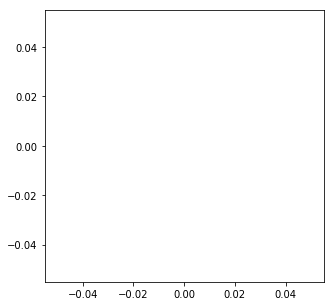

In [85]:
filt = 'I'

colors = ['r','b','g','c','m','y','#7D329F','#E0759F','#EDAC63']

std_star = pd.read_csv('HG87_'+filt+'_AIJ.csv')
ref_stars = pd.read_csv(year+'V410ref_star_data_'+filt+'.csv')
std_zp_col =[col for col in std_star.columns if 'Zero_Point' in col]
if filt =='V':
    ref_zp_col = [col for col in ref_stars.columns if 'Zero_Point' in col]
else:
    ref_zp_col = [col for col in ref_stars.columns if 'APASS Zero_Point' in col]
    
std_phot = np.where((std_star['J.D.-240000']<58507) & (std_star['J.D.-240000']>58506))[0]
ref_phot = np.where((ref_stars['J.D.-240000']<58507) & (ref_stars['J.D.-240000']>58506))[0]

r_ind = 0
e_ind = 1
plt.subplots(figsize=(5,5))
sum_zp = np.zeros(len(ref_ind))
for ii in range(0,8):
    #yerr = ref_stars[ref_zp_col[e_ind]][ref_phot],fmt='o',color=colors[ii]
    plt.plot(ref_stars['AIRMASS'][ref_phot],ref_stars[ref_zp_col[r_ind]][ref_phot],'o')
    #plt.errorbar(ref_stars['AIRMASS'][ref_phot],np.mean(ref_stars[ref_zp_col[r_ind]])[ref_phot],yerr = ref_stars[ref_zp_col[e_ind]][ref_phot],fmt='r*')
    #sum_zp = sum_zp + ref_stars[ref_zp_col[r_ind]]
    print(ref_zp_col[r_ind]+' color is '+colors[ii])
    r_ind=r_ind+2
    e_ind=e_ind+2

# if filt == 'V':
#     plt.errorbar(std_star['AIRMASS'][std_phot],std_star[std_zp_col[0]][std_phot],yerr = std_star[std_zp_col[1]][std_phot],fmt='k*',markersize=15)
# else:
#     zeropoint = sloan_std[filt+'mag']-std_star['Ins_Mag']
#     zero_point_e = ((sloan_std[filt+'_e']**2)+(std_star['Ins_Mag_err']**2))**0.5
#     plt.errorbar(std_star['AIRMASS'][std_phot],zeropoint[std_phot],yerr = zero_point_e[std_phot],fmt='k*',markersize=15)

sum_ref = np.zeros(len(ref_stars))
mean_den = np.zeros(len(ref_stars))
for img in range(0,len(ref_stars)):

    for ii in range(0,16,2):
        sum_ref[img] = ref_stars.iloc[img][ref_zp_col[ii]]/(ref_stars.iloc[img][ref_zp_col[ii+1]]**2)+sum_ref[img]
        mean_den[img] = (1/(ref_stars.iloc[img][ref_zp_col[ii+1]]**2))+mean_den[img]


mean_ref = sum_ref/mean_den
d_mean_ref = {'Mean_ZP':mean_ref}
df_mean_ref = pd.DataFrame(data=d_mean_ref,dtype=float)
mean_ref_e = (1/mean_den)**0.5
d_mean_ref_e = {'Mean_ZP_err':mean_ref_e}
df_mean_ref_e = pd.DataFrame(data=d_mean_ref_e,dtype=float)

#AIJ_dataframe(ind,num,master_data,Photometry,ePhotometry,Names,Times,AirMass,ExTime,filtname,im_info,**kwargs)
for hh in range(0,len(tar_ind)):
    if hh==0:
        tar_AIJ=AIJ_dataframe(tar_ind[hh],'tar_'+str(hh),master_data,Photometry,ePhotometry,Names,Times,AirMass,ExTime,filt,True,False)
        tar_AIJ['tar_'+str(hh)+'_calmag'] = tar_AIJ['tar_'+str(hh)+' Ins_Mag']-mean_ref
        tar_AIJ['tar_'+str(hh)+'_cal_magerr_'] = ((mean_ref_e**2)+(tar_AIJ['tar_'+str(hh)+' Ins_Mag_err']**2))**0.5
        #tar_AIJ = pd.concat([tar_AIJ,tar_AIJ_temp],axis=1)
    else:
        tar_AIJ_temp=AIJ_dataframe(tar_ind[hh],'tar_'+str(hh),master_data,Photometry,ePhotometry,Names,Times,AirMass,ExTime,filt,False,False)
        tar_AIJ_temp['tar_'+str(hh)+'_calmag'] = tar_AIJ_temp['tar_'+str(hh)+' Ins_Mag']-mean_ref
        tar_AIJ_temp['tar_'+str(hh)+'_cal_magerr_'] = ((mean_ref_e**2)+(tar_AIJ_temp['tar_'+str(hh)+' Ins_Mag_err']**2))**0.5
        tar_AIJ = pd.concat([tar_AIJ,tar_AIJ_temp],axis=1)
tar_AIJ.to_csv(datadir+'/'+filt+'_Combined/'+field+'/'+field+'target_star_data_'+filt+year+'.csv')
# plt.xlabel('Airmass')
# plt.ylabel('Zero-point (mag)')
#plt.ylim(22.8,25)

In [83]:
#ref_stars[ref_zp_col[r_ind]]
tar_AIJ

,Label,J.D.-240000,AIRMASS,EXPTIME,tar_0 RAJ2000,tar_0 DEJ2000,tar_0 X_pos,tar_0 Y_pos,tar_0 Photometry,tar_0 Photometry_err,...,tar_10 RAJ2000,tar_10 DEJ2000,tar_10 X_pos,tar_10 Y_pos,tar_10 Photometry,tar_10 Photometry_err,tar_10 Ins_Mag,tar_10 Ins_Mag_err,tar_10_calmag,tar_10_cal_magerr_
0,sc_20180114V1.fits,58132.19362,1.007,60.0,64.456367,28.225645,47.519116,863.436799,2960.821363,136.653445,...,64.897739,28.455986,3313.97368,2852.67127,18100.832429,174.127328,-6.198868,0.010445,NaN,NaN
1,sc_20180114V2.fits,58132.20193,1.013,30.0,64.456367,28.225645,47.519116,863.436799,NaN,82.050037,...,64.897739,28.455986,3313.97368,2852.67127,4136.119901,99.979215,-5.348680,0.026245,NaN,NaN
2,sc_20180115V1.fits,58133.14440,1.014,90.0,64.456367,28.225645,47.519116,863.436799,2601.957990,126.985617,...,64.897739,28.455986,3313.97368,2852.67127,21262.660767,174.584460,-5.933438,0.008915,16.476843,0.019835
3,sc_20180115V2.fits,58133.16214,1.003,90.0,64.456367,28.225645,47.519116,863.436799,3751.251346,120.431410,...,64.897739,28.455986,3313.97368,2852.67127,27157.409855,180.301031,-6.199115,0.007208,16.459640,0.019020
4,sc_20180115V3.fits,58133.17590,1.002,90.0,64.456367,28.225645,47.519116,863.436799,3982.832090,123.827116,...,64.897739,28.455986,3313.97368,2852.67127,28007.870950,183.885708,-6.232594,0.007128,16.475847,0.018977
5,sc_20180115V4.fits,58133.18888,1.006,90.0,64.456367,28.225645,47.519116,863.436799,6459.940131,275.541916,...,64.897739,28.455986,3313.97368,2852.67127,26653.429881,302.418255,-6.178776,0.012319,16.486437,0.021752
6,sc_20180115V5.fits,58133.28062,1.203,90.0,64.456367,28.225645,47.519116,863.436799,3651.827618,283.269630,...,64.897739,28.455986,3313.97368,2852.67127,28359.294564,315.035596,-6.246132,0.012061,16.466222,0.021601
7,sc_20180115V6.fits,58133.29168,1.255,90.0,64.456367,28.225645,47.519116,863.436799,3287.495952,157.472427,...,64.897739,28.455986,3313.97368,2852.67127,27723.804511,208.793500,-6.221526,0.008177,16.455211,0.019456
8,sc_20180116V1.fits,58134.12478,1.032,10.0,64.456367,28.225645,47.519116,863.436799,3382.792372,105.975849,...,64.897739,28.455986,3313.97368,2852.67127,26565.921857,170.481838,-8.560812,0.006968,16.495028,0.018909
9,sc_20180116V2.fits,58134.14840,1.009,90.0,64.456367,28.225645,47.519116,863.436799,3795.302284,184.869018,...,64.897739,28.455986,3313.97368,2852.67127,27895.147709,229.597248,-6.228215,0.008936,16.498065,0.019808


In [120]:
def detrend(idx, Photometry_initial, ePhotometry, nstars, sn_thresh):
    '''
    detrend the background for each night to find least variable comparison stars
    
    inputs
    -------
    idx                 :   list - list of indices of target stars
    Photometry_initial  :   list - list of flux values from aperture photometry
    ePhotometry         :   list - list of flux errors from aperture photometry
    nstars              :   float - number of stars in the field
    sn_thresh           :   float - S/N threshold of what is considered a star or not (good value to use: 3)
    
    outputs
    --------
    Photometry_fin_mask :   list - final aperture photometry of sources with bad sources masked out  
    cPhotometry_mask    :   list - detrended aperture photometry with bad sources masked out
    
    '''
    #determine S/N of all sources
    sn = Photometry_initial / ePhotometry
    
    #mask out bad photometry: photometry < 0, S/N is less than threshold
    Photometry_mask1 = ma.masked_where(Photometry_initial <= 0, Photometry_initial)
    Photometry_mask2 = ma.masked_where(sn < sn_thresh, Photometry_mask1)
    #mask out target stars
    m = np.zeros_like(Photometry_mask2)
    m[:,idx] = 1
    Photometry_fin_mask = ma.masked_array(Photometry_mask2, m)
       
    #find median of all photometry
    med_val = np.median(Photometry_fin_mask, axis=0)
    
    #mask out photometry where the median value is < 0
    c = np.zeros_like(Photometry_fin_mask)
    c[:,med_val<=0] = 1

    # get median flux value for each star (find percent change)
    cPhotometry = ma.masked_array(Photometry_fin_mask, c)
    cPhotometry = cPhotometry / med_val

    # do a check for outlier photometry?
    for night in np.arange(len(cPhotometry)):
        # remove large-scale image-to-image variation to find best stars
        cPhotometry[night] = cPhotometry[night] / np.median(cPhotometry[night])
    # eliminate stars with outliers from consideration 
    cPhotometry_mask = ma.masked_where( ((cPhotometry < 0.5) | (cPhotometry > 1.5)), cPhotometry)
    
    return Photometry_fin_mask, cPhotometry_mask

Text(0, 0.5, 'Magnitude')

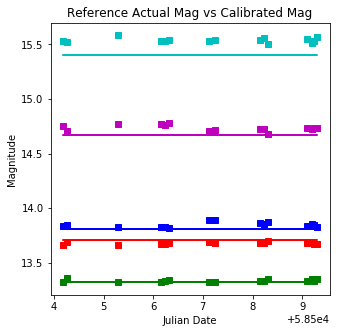

In [138]:
filt = 'R'
ref_stars = pd.read_csv(year+'V410ref_star_data_'+filt+'.csv')

r_ind = 0
e_ind = 1
ref_ins_col = [col for col in ref_stars.columns if 'Ins_Mag' in col]
tar_ins_col = [col for col in tar_AIJ.columns if 'Ins_Mag' in col]
ref_act_col = [col for col in ref_stars.columns if 'APASS(R)' in col]
plt.subplots(figsize=(5,5))
sum_zp = np.zeros(len(tar_ind))
for ii in range(0,5):
    #yerr = ref_stars[ref_zp_col[e_ind]][ref_phot],fmt='o',color=colors[ii]
    
    #plt.plot(ref_stars['J.D.-240000'],ref_stars[ref_act_col[r_ind]]-ref_stars[ref_ins_col[r_ind]]-ref_stars[ref_zp_col[r_ind]],'o',color=colors[ii])
    plt.plot(ref_stars['J.D.-240000'],ref_stars[ref_ins_col[r_ind]]-mean_ref,'s',color=colors[ii])
    plt.plot(ref_stars['J.D.-240000'],ref_stars[ref_act_col[r_ind]],color=colors[ii])
#     plt.plot(tar_AIJ['J.D.-240000'],tar_AIJ[tar_ins_col[r_ind]]/np.median(tar_AIJ[tar_ins_col[r_ind]]),'o')
    #plt.plot(ref_stars['J.D.-240000'],ref_stars[ref_zp_col[r_ind]]-mean_ref[ii],'o')
    #plt.plot(tar_AIJ['J.D.-240000'],tar_AIJ[tar_ins_col[r_ind]],'o')
    
    #plt.errorbar(ref_stars['AIRMASS'][ref_phot],np.mean(ref_stars[ref_zp_col[r_ind]])[ref_phot],yerr = ref_stars[ref_zp_col[e_ind]][ref_phot],fmt='r*')
    #sum_zp = sum_zp + ref_stars[ref_zp_col[r_ind]]
    #print(ref_zp_col[r_ind]+' color is '+colors[ii])
    #print(ref_stars[ref_ins_col[r_ind]][0])
    r_ind=r_ind+2
    e_ind=e_ind+2
#plt.plot(ref_stars['J.D.-240000'],mean_ref,'k*')
plt.title('Reference Actual Mag vs Calibrated Mag')
plt.xlabel('Julian Date')
plt.ylabel('Magnitude')
#plt.ylim([0.85,1.05])


In [125]:
ref_stars[ref_ins_col]

,ref_0 Ins_Mag,ref_0 Ins_Mag_err,ref_1 Ins_Mag,ref_1 Ins_Mag_err,ref_2 Ins_Mag,ref_2 Ins_Mag_err,ref_3 Ins_Mag,ref_3 Ins_Mag_err,ref_4 Ins_Mag,ref_4 Ins_Mag_err,ref_5 Ins_Mag,ref_5 Ins_Mag_err,ref_6 Ins_Mag,ref_6 Ins_Mag_err,ref_7 Ins_Mag,ref_7 Ins_Mag_err,ref_8 Ins_Mag,ref_8 Ins_Mag_err
0,-9.696172,0.002256,-9.542212,0.002433,-10.039012,0.001912,-7.837198,0.005963,-8.593450,0.003934,-9.923906,0.002021,-9.185311,0.002903,-7.997584,0.005442,-9.357428,0.002665
1,-9.686086,0.002272,-9.524253,0.002460,-10.022113,0.001931,-7.819364,0.006085,-8.588603,0.003966,-9.917608,0.002030,-9.174289,0.002930,-7.987473,0.005521,-9.347351,0.002686
2,-9.640779,0.002333,-9.497082,0.002505,-9.976556,0.001979,-7.782620,0.006322,-8.541794,0.004106,-9.885613,0.002069,-9.147471,0.002988,-7.954684,0.005711,-9.318076,0.002740
3,-8.643592,0.002380,-8.463041,0.002603,-8.976651,0.002023,-6.768827,0.006491,-7.552933,0.004164,-8.870937,0.002130,-8.112985,0.003105,-6.924237,0.005922,-8.296857,0.002829
4,-9.002160,0.003308,-8.840551,0.003746,-9.326611,0.002597,-7.164514,0.015223,-7.985909,0.007494,-9.233631,0.002781,-8.529383,0.004790,-7.365045,0.012769,-8.678744,0.004252
5,-9.761299,0.002151,-9.599890,0.002321,-10.104664,0.001831,-7.888361,0.005363,-8.701908,0.003571,-9.996266,0.001926,-9.269856,0.002715,-8.055058,0.004925,-9.445758,0.002497
6,-9.632277,0.002289,-9.431267,0.002519,-10.002624,0.001922,-7.790092,0.005683,-8.611977,0.003744,-9.893218,0.002024,-9.165735,0.002860,-7.967507,0.005181,-9.363736,0.002601
7,-9.065138,0.002998,-8.897323,0.003251,-9.402136,0.002552,-7.236645,0.007623,-8.026523,0.005011,-9.305103,0.002672,-8.586229,0.003785,-7.415986,0.006908,-8.775688,0.003450
8,-9.669567,0.002253,-9.497048,0.002446,-10.013942,0.001915,-7.807552,0.005679,-8.612072,0.003761,-9.898622,0.002022,-9.165638,0.002868,-7.971489,0.005209,-9.355212,0.002618
9,-9.430282,0.002607,-9.272482,0.002824,-9.751497,0.002220,-7.530092,0.007569,-8.371846,0.004574,-9.662483,0.002320,-8.923252,0.003387,-7.717655,0.006728,-9.122520,0.003051


In [49]:
filters = ['V','R','I']
coul = 'g','y','r'
for ind, filt in enumerate(filters):
    tar_stars = pd.read_csv('V410target_star_data_'+filt+year'.csv')
    for n in range(0,len(tar_ind)):
        fig, ax = plt.subplots()
        plt.errorbar(tar_AIJ['J.D.-240000'],tar_AIJ['tar_'+str(n)+'_cal_mag'],yerr=tar_AIJ['tar_'+str(n)+'_cal_mag_err'],fmt='o',color=coul[ind])
        plt.title(tar_name[n]+' '+filt)
        #plt.errorbar(tar_AIJ['J.D.-240000'],mean_ref,yerr=tar_AIJ['tar_'+str(n)+'_cal_mag_err'],fmt='o',marker='*',markersize=15,linestyle='None')

FileNotFoundError: File b'V410target_star_data_V.csv' does not exist

In [63]:
filt = 'V'

std_star = pd.read_csv('HG87_'+filt+'_AIJ.csv')
ref_stars = pd.read_csv('V410ref_star_data_'+filt+'.csv')
std_zp_col =[col for col in std_star.columns if 'Zero_Point' in col]
ref_zp_col = [col for col in ref_stars.columns if 'Zero_Point' in col]

std_phot = np.where((std_star['J.D.-240000']<58507) & (std_star['J.D.-240000']>58506))[0]
ref_phot = np.where((ref_stars['J.D.-240000']<58507) & (ref_stars['J.D.-240000']>58506))[0]
weight = np.zeros((len(ref_ind),len(ref_phot)))

if filt=='V':
    zeropoint = std_star[std_zp_col[0]]
else:
    zeropoint = sloan_ref[filt+'mag']-std_star['Ins_Mag']

for ii in range(0,len(ref_phot)):
    r_ind = 0
    for jj in range(0,len(ref_ind)):
        #chi[ii,jj] = ((ref_stars[ref_zp_col[r_ind]][ref_phot[jj]]-std_star[std_zp_col[0]][std_phot[jj]])**2)/std_star[std_zp_col[0]][std_phot[jj]]
        weight[jj,ii] = 1-(zeropoint[std_phot[ii]]-ref_stars[ref_zp_col[r_ind]][ref_phot[ii]])
        
        r_ind = r_ind+2

print(weight)

[[ 0.85206952  0.86435227  0.92956638]
 [ 0.8440697   0.84966458  0.9242258 ]
 [ 0.88473404  0.90332946  0.96223056]
 [ 0.75758519  0.75922117  0.82646015]
 [ 1.02124628  1.01726935  1.08155777]
 [ 0.87430651  0.8845715   0.95553588]
 [ 0.90334104  0.91084151  0.98137989]
 [ 0.86641322  0.87768857  0.93320023]
 [ 0.88796339  0.89490394  0.97505194]]


In [113]:
len(ref_stars)


15

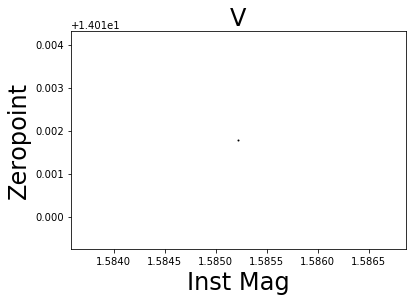

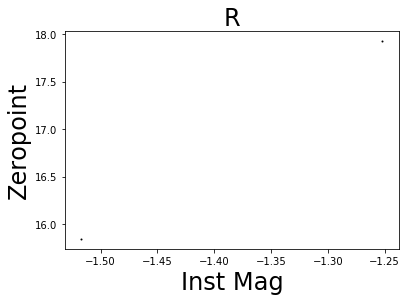

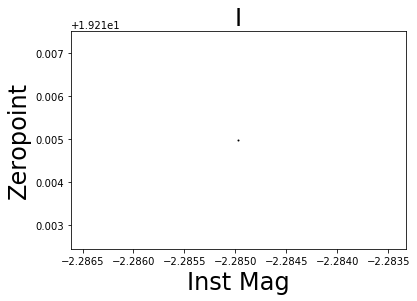

In [22]:
plt.figure()
img = 0
for filtername in filters:
    plt.figure()
    plt.scatter(flux[filtername][img,:],zero_p[filtername][img,:],color='black',s=1.)
    #plt.scatter(m_flux[filtername][img,:], m_zero_p[filtername][img,:], color='red',s=10)
    plt.xlabel('Inst Mag',size=24)
    plt.ylabel('Zeropoint',size=24)
    plt.title(filtername,size=24)

<Figure size 432x288 with 0 Axes>

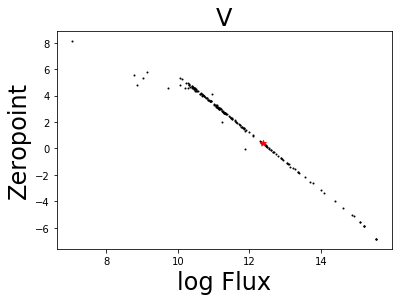

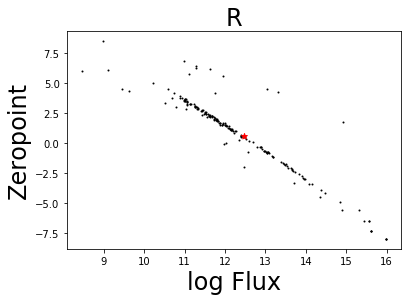

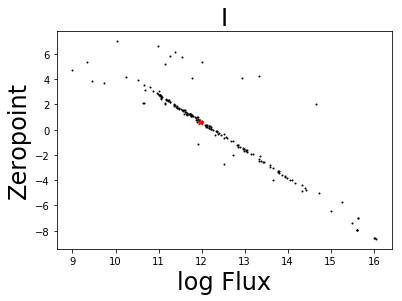

In [102]:
img = 0
for filt in filters:
    print(filt)
    for img in range(0,3):
        print('IMG '+str(img))
        print(m_zero_p[filt][img])
        print(np.nanmean(zero_p[filt][img,:]))

V
IMG 0
[0.37970209]
1.8314521426367125
IMG 1
[0.37856354]
1.8384190172931605
IMG 2
[0.5037504]
1.969936599108555
R
IMG 0
[0.54506142]
0.9188925052501284
IMG 1
[0.52478321]
0.9073189187676104
IMG 2
[0.55716975]
0.922629172108333
I
IMG 0
[0.58117698]
0.07920397817603984
IMG 1
[0.61948448]
0.1700185257082769
IMG 2
[0.6324596]
0.18906126108906332


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


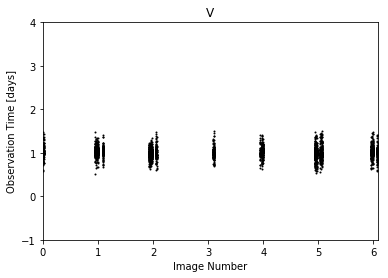

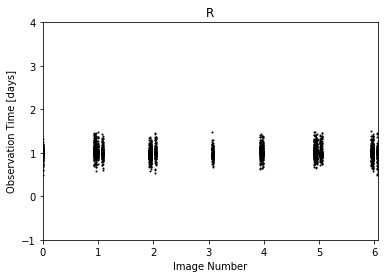

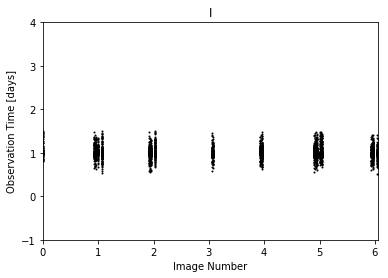

In [22]:
# detrend all stars


cPhotometry = {}

for filtername in filters: #for every filter

    nimages = len(Photometry[filtername][:,0]) #the number of images from photometry in filter
    imgindex = np.arange(0,nimages,1) #the index of the images
    cPhotometry[filtername] = np.zeros_like(Photometry[filtername]) #an array of zeros the same size as Photometry


    # get median flux value for each star (find percent change)
    for star in range(0,nstars): #for every star in the filter
        # apply an SN cut?
        SNval = Photometry[filtername][:,star]/ePhotometry[filtername][:,star] #a signal to noise cut?
        
        low_sn = np.where(SNval < 3.) #finding low signal to noise
        # blank out bad photometry
        #print(len(low_sn[0]))
        Photometry[filtername][low_sn,star] = np.nan #naning low SN
        
        # now find the median
        med_val = np.nanmedian(Photometry[filtername][:,star]) #taking the median of... each star? oh over all im
        
        if med_val <= 0.0: # known bad photometry
            cPhotometry[filtername][:,star] = Photometry[filtername][:,star]*np.nan #nan if med less than 0
        else:
            cPhotometry[filtername][:,star] = Photometry[filtername][:,star]/med_val #average the phot otherwise
            
        # do a check for outlier photometry?
        


    # remove large-scale image-to-image variation to find best stars
    for night in range(0,nimages):
        cPhotometry[filtername][night,:] = cPhotometry[filtername][night,:]/np.nanmedian(cPhotometry[filtername][night])

    # eliminate stars with outliers from consideration
    for star in range(0,nstars):
        w = np.where( (cPhotometry[filtername][:,star] < 0.5) | (cPhotometry[filtername][:,star] > 1.5))
        cPhotometry[filtername][w,star] = np.nan
        

for filtername in filters:
    
    plt.figure()
    # check how we did via plot
    for star in range(0,100):
        plt.scatter(Times[filtername]-np.nanmin(Times[filtername]),cPhotometry[filtername][:,star],s=1.,color='black')



    plt.ylim(-1.,4.)
    plt.xlim(0,np.max(Times[filtername]-np.nanmin(Times[filtername])))

    plt.ylabel('Observation Time [days]')
    plt.xlabel('Image Number')
    plt.title(filtername)

In [77]:
filtername='R'
#np.where( (star_err < accuracy_threshold) & (np.nanmedian(Photometry[filtername],axis=0) > 100.) )
#np.where( (np.nanmedian(Photometry[filtername],axis=0)< 1000.) & (np.nanmedian(Photometry[filtername],axis=0) > 100.) )
#print(np.where( (star_err < accuracy_threshold) ))
#print(np.where( (np.nanmedian(Photometry[filtername],axis=0)< 10000.) ))
np.where( (star_err < accuracy_threshold) &(np.nanmedian(Photometry[filtername],axis=0) > 100.) & (np.nanmedian(Photometry[filtername],axis=0)< 10000.))[0]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


array([ 23,  63, 115, 183, 207, 232, 236, 267, 320, 332, 342, 343, 363,
       415, 433, 441, 448, 471, 489, 494, 530])

/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10


19 : [ 23  63 115 183 207]
[ 3.83621594  3.86345953  3.83842521  3.88608304  3.85353012  3.75336063
  3.75362979  3.21776072  3.77219976  3.71664228  3.69716178  3.95359138
  3.84625757  3.92214506  3.94076783  3.68526041  3.8239866   3.95394458
  3.74152564] [-1.67306931 -1.70197771 -1.74099065 -1.72093487 -1.63261212 -1.6061416
 -1.66540989 -2.10046768 -1.65279632 -1.68696953 -1.69816162 -1.64481029
 -1.61370168 -1.70266048 -1.80179225 -1.60729571 -1.77559184 -1.64154639
 -1.62040018]


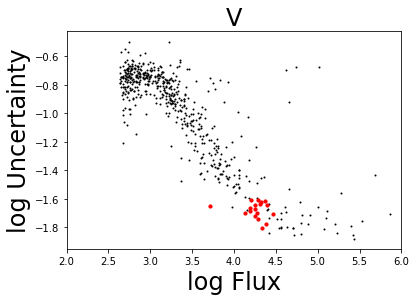

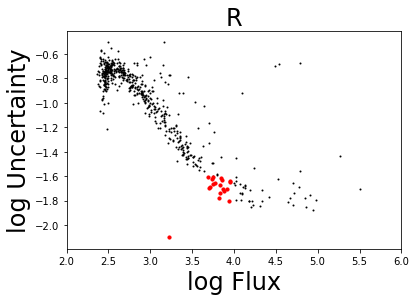

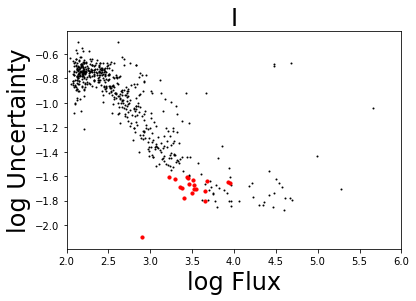

In [81]:
# select the stars with which to do the comparison

filtername='R'

star_err = np.nanstd(cPhotometry[filtername],axis=0)

accuracy_threshold = 0.025

# we may also want a flux cut?
most_accurate = np.where( (star_err < accuracy_threshold) & (star_err > 0.) & (np.nanmedian(Photometry[filtername],axis=0) < 10000.) & (np.nanmedian(Photometry[filtername],axis=0) > 100.))[0]

print(len(most_accurate),':',most_accurate[0:5])
#plt.plot(star_err[star_err.argsort()])

# select stars based on the R band similar brightness?

# choose a representative star from different magnitude bands.

plt.figure()

print(np.log10(np.nanmedian(Photometry[filtername],axis=0))[most_accurate],np.log10(star_err)[most_accurate])



for filtername in filters:
    plt.figure()
    plt.scatter(np.log10(np.nanmedian(Photometry[filtername],axis=0)),np.log10(star_err),color='black',s=1.)
    plt.scatter(np.log10(np.nanmedian(Photometry[filtername],axis=0))[most_accurate],np.log10(star_err)[most_accurate],color='red',s=10.)
    plt.xlabel('log Flux',size=24)
    plt.ylabel('log Uncertainty',size=24)
    plt.title(filtername,size=24)
    plt.xlim(2,6)

In [82]:
# calculate each star's median value


dPhotometry = {}

# carried error from photometry
edPhotometry = {}

# error on differential photometry alone
eedPhotometry = {}

# total error
tePhotometry = {}


for filtername in filters:
    print(filtername)
    


    
    nimages = len(Photometry[filtername][:,0])
    
    imgindex = np.arange(0,nimages,1)



    dPhotometry[filtername] = np.zeros_like(Photometry[filtername])
    edPhotometry[filtername] = np.zeros_like(Photometry[filtername])
    eedPhotometry[filtername] = np.zeros_like(Photometry[filtername])
    tePhotometry[filtername] = np.zeros_like(Photometry[filtername])


    for star in range(0,nstars):

        tmp_phot = np.zeros([nimages,len(most_accurate)])

        for compindex,comp in enumerate(most_accurate):
            tmp_phot[:,compindex] = (Photometry[filtername][:,star]*np.nanmedian(Photometry[filtername][:,comp]))\
                                /(Photometry[filtername][:,comp]*np.nanmedian(Photometry[filtername][:,star]))

        dPhotometry[filtername][:,star] = np.nanmedian(tmp_phot,axis=1)

        # apply final scaling factors to the photometric error
        edPhotometry[filtername][:,star] = ePhotometry[filtername][:,star]*(np.nanmedian(tmp_phot,axis=1)/Photometry[filtername][:,star])

        # the differential photometry error
        eedPhotometry[filtername][:,star] = np.nanstd(tmp_phot,axis=1)

        # the differential photometry error
        tePhotometry[filtername][:,star] = ((ePhotometry[filtername][:,star]*(np.nanmedian(tmp_phot,axis=1)/Photometry[filtername][:,star]))**2. +\
                                            (np.nanstd(tmp_phot,axis=1))**2.)**0.5




V


/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


R
I


36
1.64256756757
34
0.376016149068
34
0.375913043479


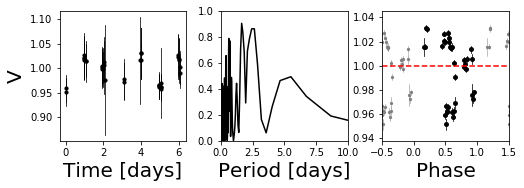

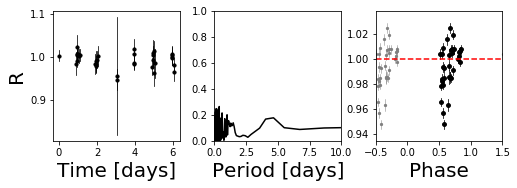

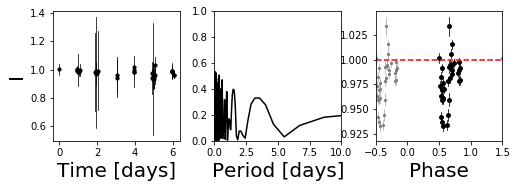

In [83]:

star = 12



for fnum,filtername in enumerate(filters):
    

    TT = Times[filtername]-np.nanmin(Times[filtername])
    DD = dPhotometry[filtername][:,star]
    ED = tePhotometry[filtername][:,star]

    w = np.where(np.isfinite(TT) & np.isfinite(DD) & np.isfinite(ED))
    
    print(len(w[0]))

    ls = LombScargle(TT[w],DD[w],ED[w])
    
    try:
        frequency, power = ls.autopower()
    except:
        print('failed in {}'.format(filtername))
        continue
        
    fig = plt.figure(fnum,figsize=(8,3))

    ax0 = fig.add_axes([0.2,0.2,0.22,0.6])
    ax1 = fig.add_axes([0.48,0.2,0.22,0.6])
    ax2 = fig.add_axes([0.76,0.2,0.22,0.6])




    nimages = len(DD)




    ax0.scatter(TT,DD,color='black',s=10.)

    for num in range(0,nimages):
        ax0.plot([TT[num],TT[num]],\
                 [DD[num]-ED[num],DD[num]+ED[num]],\
                 color='black',lw=0.75,zorder=-9)


    ax0.set_xlabel('Time [days]',size=20)
    ax1.set_xlabel('Period [days]',size=20)
    ax0.set_ylabel(filtername,size=20)
    #ax0.set_xlim(0.,3.)

    ax1.plot(1./frequency,power,color='black')
    ax1.set_xlim(0.,10.)
    ax1.set_ylim(0.,1.)
    
    w = np.where( (1./frequency > 0.2) & (1./frequency < 4.))

    best_frequency = frequency[w][np.argmax(power[w])]

    print(1./best_frequency)
    newtime = TT % (1./best_frequency)

    #print(newtime)
    newtime = newtime - np.round(newtime,0) + 0.5

           
    ax2.scatter((newtime)-1.0,DD,color='gray',s=5.)
    ax2.scatter((newtime)+1.0,DD,color='gray',s=5.)


    for num in range(0,nimages):
        ax2.plot([newtime[num]-1.,newtime[num]-1.],\
             [dPhotometry[filtername][num,star]-edPhotometry[filtername][num,star],dPhotometry[filtername][num,star]+edPhotometry[filtername][num,star]],\
             color='gray',lw=0.5,zorder=-9)
        ax2.plot([newtime[num]+1.,newtime[num]+1.],\
             [dPhotometry[filtername][num,star]-edPhotometry[filtername][num,star],dPhotometry[filtername][num,star]+edPhotometry[filtername][num,star]],\
             color='gray',lw=0.5,zorder=-9)
        ax2.plot([newtime[num],newtime[num]],\
             [dPhotometry[filtername][num,star]-edPhotometry[filtername][num,star],dPhotometry[filtername][num,star]+edPhotometry[filtername][num,star]],\
             color='black',lw=0.75,zorder=-9)




    ax2.scatter((newtime),DD,color='black',s=15.)
    


    ax2.plot([-.5,1.5],[1.,1.],color='red',linestyle='dashed')
    ax2.set_xlabel('Phase',size=20)
    #ax2.set_ylabel('Relative Photometry',size=24)
    ax2.set_xlim(-0.5,1.5)

# __TEST CODE BELOW__

In [92]:
file = open('most_accurate.reg','w') #opening a survey specific reg file
for ind in range(0,len(most_accurate)):
    file.write('circle '+str(xpos[most_accurate[ind]])+' '+str(ypos[most_accurate[ind]])+' '+str(int(aprad))+' # width=2 color=blue\n')
    
file.close()

In [87]:
ind = 0
xpos[most_accurate[ind]]

3221.9894132215322

In [95]:


survey = pd.read_csv(survey_csv[ind])
null_surv = survey.isnull()
new_survey = 0
cut1 = 'Survey Data - '
cut2 = '.csv'
stuff1 = survey_csv[ind].split(cut1)
stuff2 = stuff1[1].split(cut2)
mag_cols = [col for col in survey.columns if 'mag' in col]
data = np.empty((len(taura),len(mag_cols),))
data[:] = np.nan
len(mag_cols)
#file = open(stuff2[0]+'matched_sources.reg','w')
aprad = 8+ind
    
for star in range(0,len(survey)):
    s_ra = survey['RAJ2000'][star] #ra for survey star
    s_de = survey['DEJ2000'][star] #dec for survey star
    try:
        pot_ra = np.where(np.abs(taura-s_ra)<(3e-3))[0]
        pot_de = np.where(np.abs(taudec-s_de)<(3e-3))[0]
        for jj in range(0,len(pot_ra)):
            for rr in range(0,len(pot_de)):
                if pot_ra[jj]==pot_de[rr]:
                    #print(str(pot_ra[jj])+' , '+str(pot_de[rr]))
                    for mag in range(0,len(mag_cols)):
                        data[pot_ra[jj],mag] = survey[mag_cols[mag]][star]
                    #file.write('circle '+str(xpos[pot_ra[jj]])+' '+str(ypos[pot_de[rr]])+' '+str(int(aprad))+' # width='+str(ind+3)+' color='+color_list[ind]+'\n')
    except:
        pass

In [94]:
data = np.empty((len(taura),len(mag_cols),))
data[:] = np.nan
data[0,1] = 5
mag = 0
data[pot_ra[jj],mag] = survey[mag_cols[mag]][0]
survey[mag_cols[mag]][0]

12.694000000000001

In [31]:

survey
#for ind in range(0,len(survey['USNO-B1.0'])):
    #if survey['USNO-B1.0'][ind]=='1151-0049804':
        #print(ind)

,_RAJ2000,_DEJ2000,USNO-B1.0,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,R1mag,R2mag,Imag
0,61.142184,25.147745,1151-0049804,61.142184,25.147745,45,60,13.64,14.08,13.57
1,61.138150,25.156659,1151-0049799,61.138150,25.156659,47,55,14.45,14.81,13.87
2,61.152195,25.153537,1151-0049813,61.152195,25.153537,71,113,13.62,14.34,13.35
3,61.153173,25.154300,1151-0049816,61.153173,25.154300,411,398,18.25,18.27,NaN
4,61.140770,25.163484,1151-0049803,61.140770,25.163484,54,81,18.20,18.17,18.22
5,61.145175,25.139223,1151-0049806,61.145175,25.139223,79,118,19.95,18.80,NaN
6,61.146600,25.139787,1151-0049807,61.146600,25.139787,85,290,19.94,18.77,NaN
7,61.155217,25.147503,1151-0049817,61.155217,25.147503,48,47,18.35,18.14,17.94
8,61.123581,25.149573,1151-0049787,61.123581,25.149573,38,39,16.37,16.57,15.64
9,61.124898,25.159273,1151-0049789,61.124898,25.159273,49,53,18.49,18.25,17.68


In [46]:
new_survey = 0
for ind in range(0,len(master_data)): #for every row in master data
    null_surv = master_data.isnull() #generate a master null frame
    if null_surv[ind:ind+1].any(axis='columns')[ind]==False: #if the row has no nulls
        try:
            data = master_data[ind:ind+1] #grabbing the data at the point w/o nulls
            new_survey = new_survey.append(data,ignore_index=True) #attempting to put it into a separate survey
            print(ind)
        except AttributeError: 
            new_survey = data
            print(ind)
    
header = ["RAJ2000","DEJ2000"]
new_survey.to_csv(field+'all_surv_stars.csv', columns = header)

4
5
6
8
12
14
23
31
35
37
49
50
51
54
58
66
67
68
81
87
95
96
97
105
107
108
110
114
117
120
121
122
124
125
126
128
130
133
139
142
143
146
147
150
154
155
160
163
169
180
183
185
187
189
190
191
193
195
201
205
209
212
215
219
220
222
229
233
234
235
237
241
246
247
250
252
253
256
258
262
269
270
271
272
273
274
280
288
300
301
308
313
315
316
318
319
323
328
329
334
339
343
348
349
350
351
352
354
361
363
365
370
372
375
377
379
381
382
384
385
389
391
392
394
396
397
403
408
409
412
413
414
415
416
417
419
423
424
432
434
437
439
455
456
457
464
471
475
476
478
487
491
493
497
507
508
509
513
516
518
521
522
543
549
550
560
565
566
567
569
574
583
592
595
600
603
608
610
614
624
633
634
637
641
655
658
665
667
671
672
676


In [31]:
master_data.

RAJ2000          64.912204
DEJ2000          28.118184
X_pos           583.815330
Y_pos             1.631556
UCAC4 Vmag             NaN
UCAC4 e_Vmag           NaN
UCAC4 rmag             NaN
UCAC4 e_rmag           NaN
UCAC4 imag             NaN
UCAC4 e_imag           NaN
USNOB R1mag      17.610000
USNOB R2mag      17.660000
USNOB Imag       16.620000
APASS Vmag             NaN
APASS e_Vmag           NaN
Name: 0, dtype: float64

In [ ]:
for star in range(0,len(survey)):
    s_ra = survey['RAJ2000'][star] #ra for survey star
    s_de = survey['DEJ2000'][star] #dec for survey star
    try:
        pot_ra = np.where(np.abs(taura-s_ra)<(3e-3))[0]
        pot_de = np.where(np.abs(taudec-s_de)<(3e-3))[0]
        for jj in range(0,len(pot_ra)):
            for rr in range(0,len(pot_de)):
                if pot_ra[jj]==pot_de[rr]:
                    print(str(pot_ra[jj])+' , '+str(pot_de[rr]))
    except:
        pass

for star in range(0,len(survey)):
        s_ra = survey['RAJ2000'][star] #ra for survey star
        s_de = survey['DEJ2000'][star] #dec for survey star
        try:
            ra_ind = np.where(np.abs(taura-s_ra)<(5e-3))[0][0] #finding the index of the ra of the star in our survey (if it's within 5arcsec)
            de_ind = np.where(np.abs(taudec-s_de)<(5e-3))[0][0] #finding the index of the dec of the star in our survey (if it's within 5arcsec)
            if ra_ind == de_ind: #if the indexes match (the coordinates are for the same star)
                if null_surv[star:star+1].any(axis='columns')[star]==False:
                    try:
                        data = survey[star:star+1]
                        new_survey = new_survey.append(data,ignore_index=True)
                    except:
                        new_survey = data
                    file.write('circle '+str(xpos[ra_ind])+' '+str(ypos[de_ind])+' '+str(int(aprad))+' # width='+str(ind+3)+' color='+color_list[ind]+'\n')
        except:
            pass
        
        
ind = 0
survey = pd.read_csv(survey_csv[1])
new_survey = 0
null_surv = survey.isnull()
if null_surv[ind:ind+1].any(axis='columns')[ind]==False:
    try:
        data = survey[ind:ind+1]
        new_survey = new_survey.append(data,ignore_index=True)
    except:
        new_survey = data
    
new_survey

#file = open(stuff2[0]+'matched_sources.reg','w')
#aprad = 8+ind
#for star in range(0,len(survey)):
#    s_ra = survey['RAJ2000'][star] #ra for survey star
#    s_de = survey['DEJ2000'][star] #dec for survey star
#    try:
#        ra_ind = np.where(np.abs(taura-s_ra)<(15e-4))[0][0] #finding the index of the ra of the star in our survey (if it's within 5arcsec)
#        de_ind = np.where(np.abs(taudec-s_de)<(15e-4))[0][0] #finding the index of the dec of the star in our survey (if it's within 5arcsec)
#        if ra_ind == de_ind: #if the indexes match (the coordinates are for the same star)
#            file.write('circle '+str(xpos[ra_ind])+' '+str(ypos[de_ind])+' '+str(int(aprad))+' # width=3 color=red\n')
#    except:
#        pass
#    
#file.close()

In [ ]:
Phot_test = {}

filtername = 'V'
imglist = glob.glob(datadir+'*'+filtername+'*/*.fits')
nimages = len(imglist) #how many images there are
Phot_test[filtername] = np.zeros([nimages,nstars])

#posi = (xpos[ref_ind[0]],ypos[ref_ind[0]])
#aperature = CircularAperture(posi, r=aprad)
posi = (xpos[ref_ind[0]],ypos[[ref_ind[0]]])
aperture = CircularAperture(posi, r=aprad)
annulus_aperture = CircularAnnulus(posi, r_in=aprad+skybuff, r_out=aprad+skybuff+skywidth)
aper = [aperture, annulus_aperture]
for imgnum in range(0,nimages):
    
    print(imglist[imgnum].split('/')[-1])
    data_image,hdr = fits.getdata(imglist[imgnum],header=True) #getting data and header
    
    phot_table = aperture_photometry(data_image, aper)
    flux0 = np.array(phot_table['aperture_sum_0']) - \
    (area_of_ap/area_of_background)*np.array(phot_table['aperture_sum_1'])
    #
    if imgnum==1:
        phot_table[filtername+'_flux'] = flux0
    # stuff into a new matrix
    #
    Phot_test[filtername][imgnum] = flux0
    

In [8]:
from astropy.coordinates import SkyCoord
from astropy import units as u
coord = SkyCoord('04:04:34.1280174803 +25:08:51.682967467', unit=(u.hourangle, u.deg))
ra = coord.ra.degree
print(ra)
dec = coord.dec.degree
print(dec)

61.14220007283457
25.147689713185276


In [ ]:
Tzero_p = {}
Tezero_p = {}
ch_mag = ['APASS Vmag','USNOB R1mag','USNOB Imag']
ech_mag = ['APASS e_Vmag','UCAC4 e_rmag']

for filtname in filters:
    #mag_col = [col for col in master_data.columns if 'mag' in col]
    #filt_col = [col for col in mag_col if filtername in col]
    nimages = len(Inst_Mag[filtname][:,0]) #the number of images from photometry in filter
    filt_col = [col for col in ch_mag if filtname in col]
    Tzero_p[filtname] = np.zeros([nimages,len(tar_ind)])
    Tezero_p[filtname] = np.zeros([nimages,len(tar_ind)])
    for star in range(0,len(tar_ind)):
        for img in range(0,nimages):
            Tzero_p[filtname][img,star] = master_data[filt_col[0]][tar_ind[star]]-Inst_Mag[filtname][img,tar_ind[star]]
            if filtname == "V":
                surv_e = master_data['APASS e_Vmag'][tar_ind[star]]
                Tezero_p[filtname][img,star] = ((surv_e**2)+(eInst_Mag[filtname][img,tar_ind[star]]**2))**0.5
            elif filtname == "I":
                surv_e = 0.3
                Tezero_p[filtname][img,star] = ((surv_e**2)+(eInst_Mag[filtname][img,tar_ind[star]]**2))**0.5
            else:
                surv_e = 0.3
                Tezero_p[filtname][img,star] = ((surv_e**2)+(eInst_Mag[filtname][img,tar_ind[star]]**2))**0.5




In [ ]:
tar_ind = {}
num = 0

ind = 3
ra_indexes = (master_data.loc[(master_data['RAJ2000']>=(pot_tar_star_data['RA'][ind]-1e-3)) & (master_data['RAJ2000']<=(pot_tar_star_data['RA'][ind]+1e-3))].index.astype(int))
de_indexes = (master_data.loc[(master_data['DEJ2000']>=(pot_tar_star_data['DEC'][ind]-1e-3)) & (master_data['DEJ2000']<=(pot_tar_star_data['DEC'][ind]+1e-3))].index.astype(int))
col = pot_tar_star_data.columns
tar_star_data = pd.DataFrame(columns=col)
try:
    for ra_ind in range(0,len(ra_indexes)):
        for de_ind in range(0,len(de_indexes)):
            if ra_indexes[ra_ind] == de_indexes[de_ind]:
                print(ra_indexes[ra_ind])
                tar_ind[num] = ra_indexes[ra_ind]
                print(tar_ind)
                num = num+1
except:
    pass

tar_star_data.append(pot_tar_star_data.iloc[ind],ignore_index=True)



In [ ]:
zero_p = {}
flux = {}
ezero_p = {}
df_zp = {}
df_ezp = {}
ch_mag = ['APASS_'+field+' Vmag','USNOB_'+field+' R2mag','USNOB_'+field+' Imag']
ech_mag = ['APASS e_Vmag','UCAC4 e_rmag']

for filtname in filters:
    #mag_col = [col for col in master_data.columns if 'mag' in col]
    #filt_col = [col for col in mag_col if filtername in col]
    nimages = len(Inst_Mag[filtname][:,0]) #the number of images from photometry in filter
    filt_col = [col for col in ch_mag if filtname in col] #filtercolumn name
    zero_p[filtname] = np.zeros([nimages,len(ref_ind)]) #empty zeropoint calc
    flux[filtname] = np.zeros([nimages,len(ref_ind)])
    ezero_p[filtname] = np.zeros([nimages,len(ref_ind)])
    df_zp[filtname] = np.zeros([nimages,nstars])
    df_zp[filtname][:] = np.nan
    df_ezp[filtname] = np.zeros([nimages,nstars])
    df_ezp[filtname][:] = np.nan
    for star in range(0,len(ref_ind)):
        for img in range(0,nimages):
            zero_p[filtname][img,star] = master_data[filt_col[0]][ref_ind[star]]-Inst_Mag[filtname][img,ref_ind[star]]
            #flux[filtname][img,star] = Photometry[filtname][img,ref_ind[star]]
            flux[filtname][img,star] = Inst_Mag[filtname][img,ref_ind[star]]
            df_zp[filtname][img,ref_ind[star]] = zero_p[filtname][img,star]
            if filtname == "V":
                surv_e = master_data['APASS_'+field+' e_Vmag'][ref_ind[star]]
                ezero_p[filtname][img,star] = ((surv_e**2)+(eInst_Mag[filtname][img,ref_ind[star]]**2))**0.5
                df_ezp[filtname][img,ref_ind[star]] = ezero_p[filtname][img,star]
            elif filtname == "I":
                surv_e = 0.3
                ezero_p[filtname][img,star] = ((surv_e**2)+(eInst_Mag[filtname][img,ref_ind[star]]**2))**0.5
                df_ezp[filtname][img,ref_ind[star]] = ezero_p[filtname][img,star]
            else:
                surv_e = 0.3
                ezero_p[filtname][img,star] = ((surv_e**2)+(eInst_Mag[filtname][img,ref_ind[star]]**2))**0.5
                df_ezp[filtname][img,ref_ind[star]] = ezero_p[filtname][img,star]


